Imports

In [ ]:
import json
import os
import torch
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
if not '../bertviz' in sys.path:
  sys.path += ['../bertviz']
from bertviz import head_view, model_view
import IPython
from IPython.display import Javascript
from tqdm import tqdm
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import gridspec
from itertools import product
from run_bertology import compute_heads_importance, mask_heads, prune_heads
from mt_dnn.batcher import Collater
from scipy.stats import pearsonr
import random
from experiments.exp_def import TaskDefs, EncoderModelType
from mt_dnn.model import MTDNNModel
from mt_dnn.batcher import SingleTaskDataset
from torch.utils.data import DataLoader
import argparse
from datetime import datetime
from mt_dnn.loss import *
from utils import *
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import collections
!python -m spacy download en_core_web_lg
!pip install stanza
import stanza
stanza.download('en')
from tokenizers import BertWordPieceTokenizer
from spacy.tokens import Doc
import spacy
import csv
import urllib
import requests
from sklearn.preprocessing import MinMaxScaler
from nltk import ngrams
from random import randrange
import math

# Incoming from macbook
- Upload `lcp_train.tsv`, `lcp_dev.tsv`, and `lcp_test.tsv` to `new-mt-dnn/data_complex`
- Upload `{name}_p.tsv`'s to `from_macbook/`

# MT-DNN model

In [ ]:
!python prepro_std.py --model bert-base-cased --root_dir data_complex/ --task_def data_complex/lcp.yml

In [ ]:
!python train.py --task_def data_complex/lcp.yml --data_dir data_complex/bert_base_cased/ --train_datasets lcp --test_datasets lcp --multi_gpu_on --init_checkpoint mt_dnn_models/bert_model_base_cased.pt --output_dir checkpoints/bert-cased_lcp-single_2021-01-28T0150

In [ ]:
#!python predict.py --task_def data_complex/lcp.yml --task lcp --task_id 0 --prep_input data_complex/bert_base_cased/lcp_test.json --with_label --score ./tail_bert_scores.json  --checkpoint checkpoints/bert-cased_lcp-single_2021-01-19T0309/model_4.pt

# Perplexity

## PPL by looking at entire sentence.

In [ ]:
name = 'single_test'

In [ ]:
device = 'cuda'
model_id = 'gpt2-large'
model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

In [ ]:
data = pd.read_csv('../from_macbook/{}_p.tsv'.format(name), sep='\t', index_col=0)
tokens = data['token'].tolist()
sentences = data['sentence'].tolist()
encodings = [tokenizer(sentence, return_tensors='pt') for sentence in sentences]

In [ ]:
lls = []
for i in tqdm(range(len(encodings))):
  input_ids = encodings[i].input_ids.to(device)
  target_ids = input_ids.clone()
  #target_ids[:,:-stride] = -100
  with torch.no_grad():
    try:
        outputs = model(input_ids, labels=target_ids)
        log_likelihood = outputs[0]
        lls.append(log_likelihood)
    except:
        print(input_ids)
        lls.append(-1)

In [ ]:
ppls = [torch.exp(item).cpu().data.tolist() if item != -1 else -1 for item in lls]
data['ppl'] = ppls
#data[['complexity', 'ppl']].corr()

In [ ]:
data.to_csv('../from_macbook/{}_ppl.tsv'.format(name), sep='\t')

## PPL by looking at aspect word(s) only.

In [ ]:
lls = []
for i in tqdm(range(len(encodings))):
  input_ids = encodings[i].input_ids.to(device)
  target_ids = input_ids.clone()
  sentence = sentences[i]
  token = tokens[i] 
  #token = token.split(' ')[0] # <- head
  #token = token.split(' ')[1] # <- tail
  encoded = tokenizer(sentence, return_tensors='pt')[0]
  offsets = encoded.offsets
  i = sentence.index(token)
  j = i+len(token)
  head_idx, tail_idx = None, None
  for idx, (offset_i, offset_j) in enumerate(offsets):
    if offset_i <= i:
      head_idx = idx
    if not tail_idx and offset_j >= j:
      tail_idx = idx
  target_ids[:,:head_idx] = -100
  target_ids[:,tail_idx+1:] = -100
  with torch.no_grad():
    try:
        outputs = model(input_ids, labels=target_ids)
        log_likelihood = outputs[0]
        lls.append(log_likelihood)
    except:
        print(input_ids)
        lls.append(-1)

In [ ]:
ppls = [torch.exp(item).cpu().data.tolist() if item != -1 else -1 for item in lls]
data['ppl_aspect_only'] = ppls
#data[['complexity', 'ppl_aspect_only']].corr()

In [ ]:
data.to_csv('../from_macbook/{}_ppl_aspect_only.tsv'.format(name), sep='\t')
#data.to_csv('../from_macbook/{}_ppl_aspect_only_head.tsv'.format(name), sep='\t')
#data.to_csv('../from_macbook/{}_ppl_aspect_only_tail.tsv'.format(name), sep='\t')

# Outgoing to discovery

# Playground

## Get BERT attention

In [ ]:
task_def_path = 'data_complex/lcp.yml'
checkpoint_path = 'checkpoints/bert-cased_lcp-single_2021-01-19T0309/model_4.pt'
input_path = 'data_complex/bert_base_cased/lcp_test.json'
model_type='bert-base-cased'
do_lower_case=False
use_cuda=True
# load task info
task = os.path.splitext(os.path.basename(task_def_path))[0]
task_defs = TaskDefs(task_def_path)
assert task in task_defs._task_type_map
assert task in task_defs._data_type_map
assert task in task_defs._metric_meta_map
prefix = task.split('_')[0]
task_def = task_defs.get_task_def(prefix)
data_type = task_defs._data_type_map[task]
task_type = task_defs._task_type_map[task]
metric_meta = task_defs._metric_meta_map[task]
# load model
assert os.path.exists(checkpoint_path)
state_dict = torch.load(checkpoint_path)
config = state_dict['config']
config["cuda"] = use_cuda
device = torch.device("cuda" if use_cuda else "cpu")
task_def = task_defs.get_task_def(prefix)
task_def_list = [task_def]
config['task_def_list'] = task_def_list
## temp fix
config['fp16'] = False
config['answer_opt'] = 0
config['adv_train'] = False
#del state_dict['optimizer']
config['output_attentions'] = True
config['local_rank'] = -1
model = MTDNNModel(config, device, state_dict=state_dict)
encoder_type = config.get('encoder_type', EncoderModelType.BERT)
root = os.path.basename(task_def_path)
literal_model_type = model_type.split('-')[0].upper()
encoder_model = EncoderModelType[literal_model_type]
literal_model_type = literal_model_type.lower()
mt_dnn_suffix = literal_model_type
if 'base' in model_type:
    mt_dnn_suffix += "_base"
elif 'large' in model_type:
    mt_dnn_suffix += "_large"
# load tokenizer
config_class, model_class, tokenizer_class = MODEL_CLASSES[literal_model_type]
tokenizer = tokenizer_class.from_pretrained(model_type, do_lower_case=do_lower_case)
# load data
prep_input = input_path
test_data_set = SingleTaskDataset(prep_input, False, maxlen=512, task_id=0, task_def=task_def)
collater = Collater(is_train=False, encoder_type=encoder_type)
test_data = DataLoader(test_data_set, batch_size=1, collate_fn=collater.collate_fn, pin_memory=True)

Loaded 917 samples out of 917


In [ ]:
finetuned_attention = pkl.load(open('checkpoints/bert-cased_lcp-single_2021-01-19T0309/finetuned_attention.pkl', 'rb'))
pretrained_attention = pkl.load(open('checkpoints/bert-cased_lcp-single_2021-01-19T0309/pretrained_attention.pkl', 'rb'))
_, tokenizer = load_model_for_viz_2('data_complex/lcp.yml','checkpoints/bert-cased_lcp-single_2021-01-19T0309/model_4.pt')
tokens_lst = [tokenizer.convert_ids_to_tokens(batch_data[0][0]) for batch_meta, batch_data in test_data]

## Understand BERT attention

### Data

In [ ]:
!python predict.py --task_def data_complex/lcp.yml --task lcp --task_id 0 --prep_input data_complex/bert_base_cased/lcp_test.json --with_label --score '/content/gdrive/My Drive/Colab Notebooks/cs99/new-mt-dnn/checkpoints/bert-cased_lcp-single_2021-01-19T0309/pretrained.json'  --checkpoint checkpoints/bert-cased_lcp-single_2021-01-19T0309/bert_model_base_cased.pt

In [ ]:
data = pd.read_csv('data_complex/lcp_test.tsv', sep='\t', header=None, names=['idx', 'complexity', 'sentence', 'token'])
data['complexity'] = np.load('../from_macbook/single_test_labels.npy')
data['class'] = pd.cut(data['complexity'], labels=[1,2,3,4,5], bins=[0,0.2,0.4,0.6,0.8,1], include_lowest=True)
data['sent_len'] = data['sentence'].str.len()
with open('checkpoints/bert-cased_lcp-single_2021-01-19T0309/lcp_test_scores_epoch_4.json', 'r') as file:
    single_dev_bert_scores = json.load(file)
    data['finetuned_complexity'] = single_dev_bert_scores['scores']
    data['finetuned_error'] = data['finetuned_complexity']-data['complexity']
    data['finetuned_abs_error'] = (data['finetuned_complexity']-data['complexity']).abs()
with open('checkpoints/bert-cased_lcp-single_2021-01-19T0309/pretrained.json', 'r') as file:
    single_dev_bert_scores = json.load(file)
    data['pretrained_complexity'] = single_dev_bert_scores['scores']
    data['pretrained_error'] = data['pretrained_complexity']-data['complexity']
    data['pretrained_abs_error'] = (data['pretrained_complexity']-data['complexity']).abs()
data['improvement'] = data['pretrained_abs_error']-data['finetuned_abs_error']
data['proper'] = data['token'].apply(lambda x: x[0].isupper())

In [ ]:
data.sort_values('finetuned_abs_error', ascending=True).set_index('idx').iloc[:10][['sentence', 'token', 'complexity', 'class', 'sent_len', 'finetuned_abs_error', 'pretrained_abs_error']].head(10)
#data[data['token'] == 'Ephraim'][['sentence', 'token', 'complexity', 'class', 'sent_len', 'finetuned_complexity', 'pretrained_complexity']].head(10)
#data[data['proper']][['sentence', 'token', 'complexity', 'class', 'sent_len', 'finetuned_abs_error', 'pretrained_abs_error']].sort_values('finetuned_abs_error', ascending=True).head(10)

,sentence,token,complexity,class,sent_len,finetuned_abs_error,pretrained_abs_error
idx,,,,,,,
169,"But when the Jews saw the multitudes, they were filled with jealousy, and contradicted the things which were spoken by Paul, and blasphemed.",Paul,0.235294,2,140,0.000234,1.096015
652,"They offer some comfort to footwear producers in the Union while taking into account both the interests of consumers and the changing structure of the sector within the Union, where many household names in the footwear sector now choose to manufacture outside the Union.",account,0.216667,2,270,0.000376,0.778386
702,"Finally, to take account of a problem on pre-accession assistance which arose from the Council's reading, and which we were not able to pick up quickly enough, we ask the Commission at the end of paragraph 25 of the resolution, 'to present a transfer request or amending budget during the course of 2007 if the amounts foreseen in the 2007 budget turn out to be insufficient'.",transfer,0.287500,2,376,0.000390,0.705534
879,"Mr President, animal welfare is, in fact, something that most of the citizens of Europe care about.",citizens,0.205882,2,99,0.000400,0.894336
328,"Before these questions about olfactory receptor gene choice can be answered, it will be important to measure expression levels of a larger number of genes, perhaps using an olfactory receptor gene microarray.",choice,0.187500,1,208,0.000427,0.780877
84,"It will be for a sign and for a witness to Yahweh of Armies in the land of Egypt; for they will cry to Yahweh because of oppressors, and he will send them a savior and a defender, and he will deliver them.",defender,0.279412,2,205,0.000430,1.023402
415,Our results suggest that patterned expression of Tbx15 provides an instructional cue required to establish the future identity of dorsal dermis with regard to pigmentary and hair length patterning.,identity,0.238636,2,197,0.000463,0.919740
444,"In that study, there was a tendency towards correlation in transcript abundance between several pairs of antioxidant or DNA repair genes in non-BC individuals, but not in BC individuals.",repair,0.261905,2,186,0.000875,1.044571
662,"The next item is the report by Mr Brok and Mr Gualtieri, on behalf of the Committee on Constitutional Affairs, on the amendment of the Treaty on the Functioning of the European Union with regard to a stability mechanism for Member States whose currency is the euro (00033/2010 - C7-0014/2011 - 2010/0821/NLE)).",Treaty,0.300000,2,310,0.000928,1.033760


### Paper: BertViz
- https://github.com/jessevig/bertviz

#### Layer view

In [ ]:
idx = 328

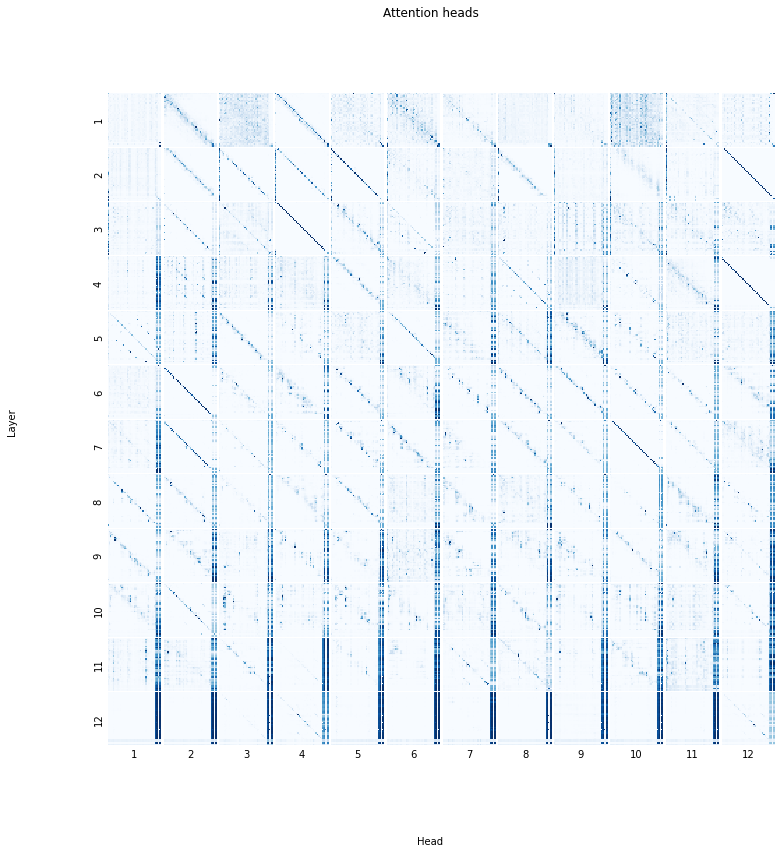

In [ ]:
size = 12
fig = plt.figure('foo', (size, size))
gs = gridspec.GridSpec(size, size)
gs.update(wspace=0., hspace=0.02)
for row in range(size):
  for col in range(size):
    ax = plt.subplot(gs[(row, col)])
    ax = sns.heatmap(finetuned_attention[idx][row, col], ax=ax, cmap="Blues", cbar=False, xticklabels=False, yticklabels=False, square=True)
    if col == 0:
      ax.set_ylabel(row+1)
    if row == size-1:
      ax.set_xlabel(col+1)
fig.suptitle("Attention heads")
fig.text(0.5, 0.01, 'Head', ha='center')
fig.text(0.01, 0.5, 'Layer', va='center', rotation='vertical')
fig.savefig('checkpoints/bert-cased_lcp-single_2021-01-19T0309/finetuned_attention.png', dpi=fig.dpi)

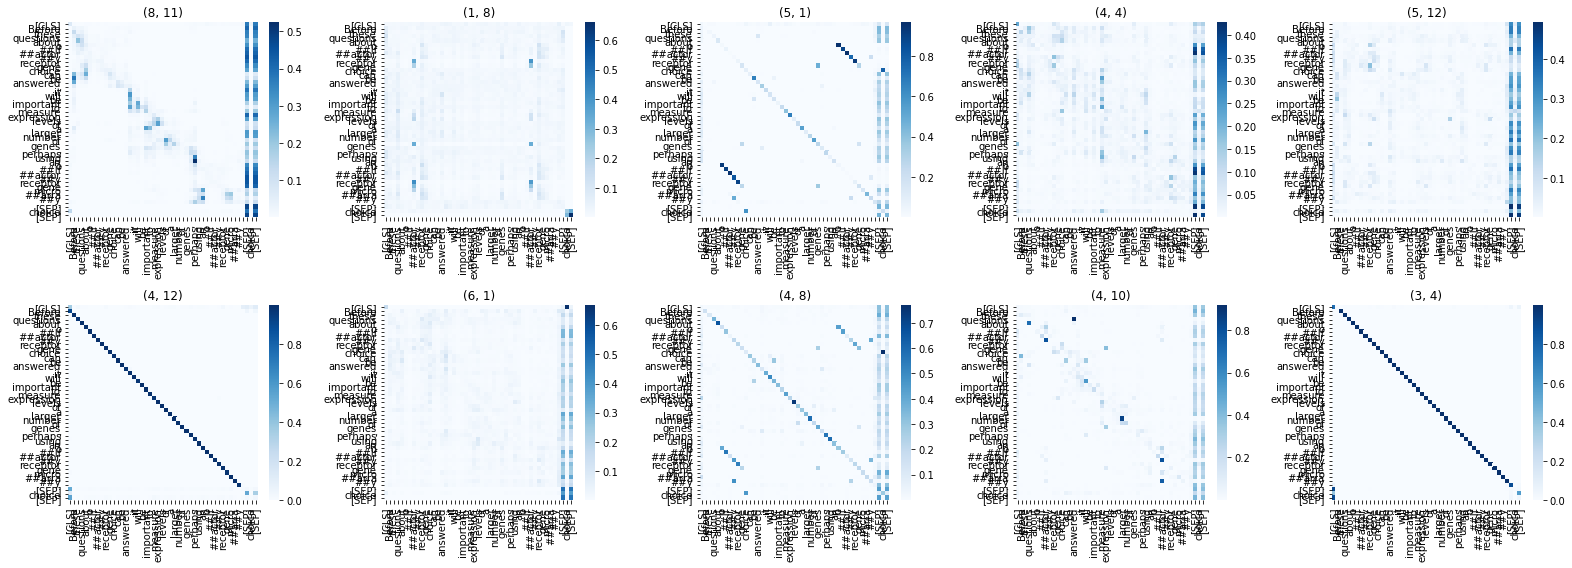

In [ ]:
idx = 328
top = 10
# before running this, build head_importance array by running later cells
i_s = product(range(12), range(12))
i_and_imp_s = zip(i_s, head_importance.ravel())
i_and_imp_s = sorted(i_and_imp_s, reverse=True, key = lambda x: x[1])
fig, axes = plt.subplots(nrows=top//5, ncols=5, figsize=(22,8))
tokens = tokens_lst[idx]
for j, (i, imp) in enumerate(i_and_imp_s):
  if j == top:
    break
  if top <= 5:
    sns.heatmap(finetuned_attention[idx][i[0], i[1], :, :], cmap="Blues", ax=axes[j], xticklabels=tokens, yticklabels=tokens)
    axes[j].set_title((i[0]+1, i[1]+1))
  else:  
    sns.heatmap(finetuned_attention[idx][i[0], i[1], :, :], cmap="Blues", ax=axes[j//5, j%5], xticklabels=tokens, yticklabels=tokens)
    axes[j//5, j%5].set_title((i[0]+1, i[1]+1))
plt.tight_layout()

#### Head view

In [ ]:
idx = 873

Text(0.5, 1.0, 'Fine-tuned')

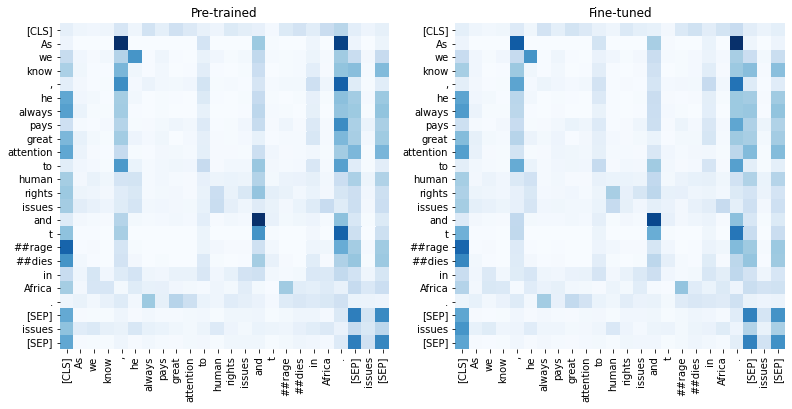

In [ ]:
layer, head = 3, 9
tokens = tokens_lst[idx]
plt.rcParams['figure.figsize'] = [13, 6]
fig, axes = plt.subplots(1, 2)
sns.heatmap(pretrained_attention[idx][layer-1, head-1], ax=axes[0], cmap="Blues", xticklabels=tokens, yticklabels=tokens, cbar=False)
axes[0].set_title('Pre-trained')
sns.heatmap(finetuned_attention[idx][layer-1, head-1], ax=axes[1], cmap="Blues", xticklabels=tokens, yticklabels=tokens, cbar=False)
axes[1].set_title('Fine-tuned')

In [ ]:
call_html()
f = tuple(finetuned_attention[idx][i].unsqueeze(0) for i in range(12))
head_view(f, tokens)

Output hidden; open in https://colab.research.google.com to view.

#### Other

In [ ]:
#attn_given_to_target = torch.stack([finetuned_attention[i][:,:,:,tokens_lst[i].index('[SEP]')+1:finetuned_attention[i].shape[3]-1].sum(dim=(2, 3))/finetuned_attention[i].shape[3] for i in range(len(finetuned_attention))])
attn_given_to_target = torch.stack([finetuned_attention[i][:,:,:,tokens_lst[i].index('[CLS]')].sum(dim=2)/finetuned_attention[i].shape[3] for i in range(len(finetuned_attention))])
corrs = np.array([np.corrcoef(attn_given_to_target[:, i, j].numpy(), data['complexity'])[0,1] for i, j in product(range(12), range(12))]).reshape(12, 12)

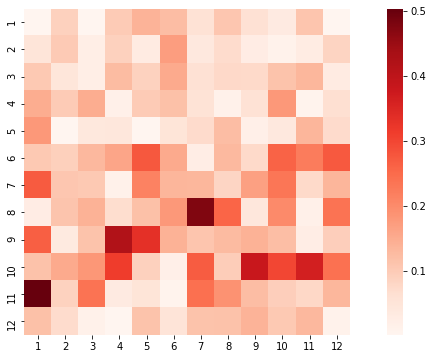

In [ ]:
sns.heatmap(np.abs(corrs), cmap="Reds", xticklabels=range(1, 12+1), yticklabels=range(1, 12+1), square=True)

#### Correlation btwn summed attention given to each token and term frequency of each token.

In [ ]:
def get_tf_of_each_word(sentence=None, i=None, tokenizer=None):
  if sentence is not None:
    tokens = tokenizer.tokenize(sentence)
  elif i is not None:
    tokens = tokens_lst[i][1:tokens_lst[i].index('[SEP]')]
  words = []
  word_i_2_token_i = {}
  for token_i, token in enumerate(tokens):
    if not token.startswith('##'):
      words.append(token)
    elif token.startswith('##'):
      words[-1] += token[2:]
    if len(words)-1 in word_i_2_token_i:
      word_i_2_token_i[len(words)-1].append(token_i)
    else:
      word_i_2_token_i[len(words)-1] = [token_i]
  results = []
  for word_i, word in tqdm(enumerate(words)):
    tf = get_tf(word)
    for token_i in word_i_2_token_i[word_i]:
      results.append(tf)
  return results

In [ ]:
idx_lst = data.sample(100).idx.to_numpy()

tf_list = []
for i in idx_lst:
  tf_list.append(get_tf_of_each_word(i=i))

token_tf_list = []
for token in tqdm(data.iloc[idx_lst]['token']):
  token_tf_list.append(get_tf_of_each_word(sentence=token, tokenizer=tokenizer))

full_tf_list = []
for item_1, item_2 in zip(tf_list, token_tf_list):
  scaler = MinMaxScaler()
  item_1_scaled = scaler.fit_transform(np.array(item_1).reshape(-1, 1))
  item_2_scaled = scaler.transform(np.array(item_2).reshape(-1, 1))
  item = item_1_scaled.ravel().tolist()+item_2_scaled.ravel().tolist()
  full_tf_list.append(item)
#pkl.dump(full_tf_list, open('checkpoints/bert-cased_lcp-single_2021-01-19T0309/tf.pkl', 'wb'))
#full_tf_list = pkl.load(open('checkpoints/bert-cased_lcp-single_2021-01-19T0309/tf.pkl', 'rb'))

In [ ]:
idx_lst

array([667,  98, 627, 701, 490, 677, 797, 506, 816, 542, 722, 484, 489,
       146, 387, 180, 114, 598, 372, 593, 517, 494, 128,  27, 553, 901,
       856, 617,  93,  39, 873, 782, 344,  37,  76, 439, 364, 411, 334,
       893, 323, 714,  24, 385, 531, 244, 638, 773,  41, 770, 139, 646,
       619, 243, 434, 898, 663,  92, 802, 527, 134, 158, 752, 143, 416,
       846, 247, 371, 326, 312, 493, 600, 306, 353, 848, 643, 222, 570,
       809,  68, 203, 604, 763, 468, 487, 233, 851, 526, 358, 442, 279,
        90, 106, 686, 538, 179, 902, 794,  44, 325])

In [ ]:
results = np.zeros((12, 12, len(idx_lst)))
for i, j in enumerate(idx_lst):
  k = np.array(list(set(range(len(tokens_lst[j])))-{0, tokens_lst[j].index('[SEP]'), len(tokens_lst[j])-1}))
  attn = finetuned_attention[j][:, :, k, :][:, :, :, k].sum(axis=2)/len(k)
  for m in range(12):
    for n in range(12):
      results[m, n, i] = np.corrcoef(attn[m, n], full_tf_list[i])[0,1]
#np.save('checkpoints/bert-cased_lcp-single_2021-01-19T0309/corr_btwn_attn_and_tf.npy', results)

In [ ]:
results = np.load('checkpoints/bert-cased_lcp-single_2021-01-19T0309/corr_btwn_attn_and_tf.npy')

Text(69.0, 0.5, 'layer')

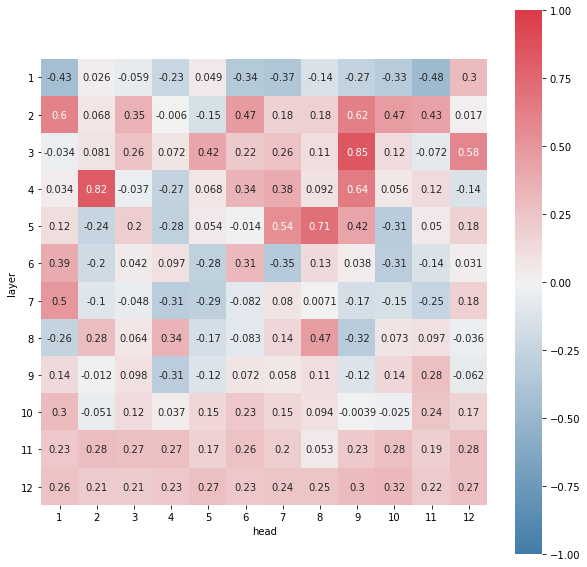

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(results.mean(axis=2), cmap=sns.diverging_palette(240, 10, sep=1, n=256), vmax=1, vmin=-1, xticklabels=range(1, 12+1), yticklabels=range(1, 12+1), square=True, annot=True, ax=ax)
plt.yticks(rotation=0)
plt.xlabel('head')
plt.ylabel('layer')

In [ ]:
data.iloc[idx_lst][data.iloc[idx_lst]['sent_len']>50].sort_values('sent_len').head(10)

,idx,complexity,sentence,token,class,sent_len,finetuned_complexity,finetuned_error,finetuned_abs_error,pretrained_complexity,pretrained_error,pretrained_abs_error,improvement,proper
770,770,0.225000,Interpretation of the Rules of Procedure: see Minutes,Interpretation,2,53,0.270055,0.045055,0.045055,-0.654513,-0.879513,0.879513,0.834458,True
90,90,0.397059,"The seers shall be disappointed, and the diviners confounded.",seers,2,61,0.408315,0.011256,0.011256,-0.703554,-1.100613,1.100613,1.089356,False
334,334,0.100000,M-AS and SA have contributed to collection of phenotype data.,collection,1,61,0.219092,0.119092,0.119092,-0.606428,-0.706428,0.706428,0.587335,False
279,279,0.333333,"Howl, you ships of Tarshish, for your stronghold is laid waste!",stronghold,2,63,0.271357,-0.061977,0.061977,-0.790621,-1.123954,1.123954,1.061977,False
180,180,0.203125,"God has gone up with a shout, Yahweh with the sound of a trumpet.",shout,2,65,0.213145,0.010020,0.010020,-0.881402,-1.084527,1.084527,1.074507,False
663,663,0.250000,Commission statement on incentives for vegetable protein production.,incentives,2,68,0.227258,-0.022742,0.022742,-0.633766,-0.883766,0.883766,0.861025,False
146,146,0.266667,"and will turn away their ears from the truth, and turn aside to fables.",fables,2,71,0.379441,0.112775,0.112775,-0.654360,-0.921027,0.921027,0.808252,False
114,114,0.100000,"""I will also make it a possession for the porcupine, and pools of water.",pools,1,72,0.204027,0.104027,0.104027,-0.645660,-0.745660,0.745660,0.641633,False
782,782,0.535714,Section V - Court of Auditors (SEC(2002) 405 - C5-0245/2002 - 2002/2105(DEC)),DEC,3,77,0.601720,0.066006,0.066006,-0.729774,-1.265488,1.265488,1.199482,True
134,134,0.430556,"On the cliff he dwells, and makes his home, on the point of the cliff, and the stronghold.",stronghold,3,90,0.311251,-0.119305,0.119305,-0.814404,-1.244959,1.244959,1.125654,False


0.9630573830399831


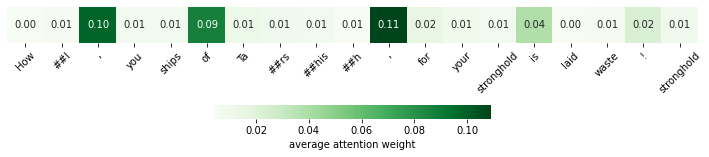

In [ ]:
i = np.where(idx_lst==279)[0][0]
idx = idx_lst[i]
layer, head = 3, 9
k = np.array(list(set(range(len(tokens_lst[idx])))-{0, tokens_lst[idx].index('[SEP]'), len(tokens_lst[idx])-1}))
tokens = np.array(tokens_lst[idx])[k]
attn = finetuned_attention[idx][layer-1, head-1, k][:, k]
attn_summed = attn.sum(axis=0)/len(k)
corr = np.corrcoef(full_tf_list[i], attn_summed)[0,1]
print(corr)
fig, ax = plt.subplots(figsize=(10,6))
_ = sns.heatmap(attn_summed.unsqueeze(dim=0), ax=ax, square=True, cmap='Greens', fmt='.2f', cbar=True, annot=True, cbar_kws={'orientation': 'horizontal', 'label': 'average attention weight', "shrink": 0.4})
_ = ax.tick_params(left=False, bottom=True)
_ = ax.set(yticklabels=[])
_ = ax.set(xticklabels=np.array(tokens_lst[idx])[k])
_ = plt.xticks(rotation=45)
_ = plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if __name__ == '__main__':


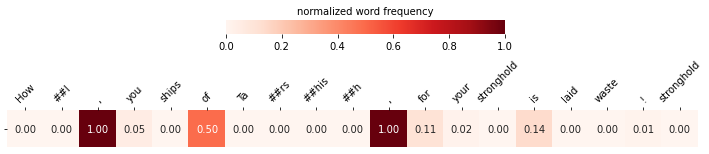

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
_ = sns.heatmap(torch.tensor(full_tf_list[i]).unsqueeze(dim=0), ax=ax, square=True, cmap='Reds', fmt='.2f', cbar=True, annot=True, cbar_kws={"shrink": .5, 'use_gridspec': False, 'location': "bottom"})
cbar = ax.collections[0].colorbar
cbar.set_label('normalized word frequency', labelpad=-45)
_ = ax.tick_params(labelbottom = False, bottom=False, top = True, labeltop=True)
_ = ax.set(yticklabels=[])
_ = ax.set(xticklabels=np.array(tokens_lst[idx])[k])
_ = plt.xticks(rotation=45)
_ = plt.tight_layout()

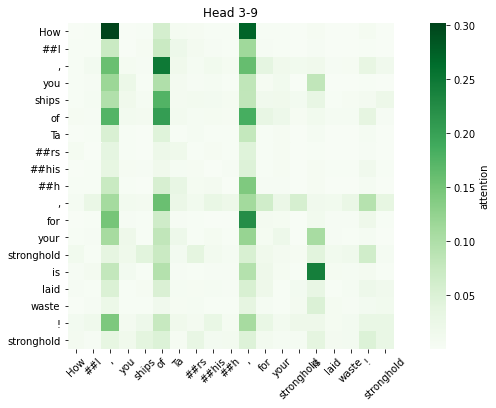

In [ ]:
sns.heatmap(attn, cmap="Greens", xticklabels=tokens, yticklabels=tokens, square=True, cbar=True, cbar_kws={'label': 'attention weight'})
_ = plt.xticks(rotation=45)
_ = plt.title('Head 3-9')

#### Correlation btwn summed attention given to each bigram and frequency of bigram.

In [ ]:
def get_tf_ngram_2_of_each_word(sentence=None, i=None, tokenizer=None, early_stop=False):
  if sentence is not None:
    tokens = tokenizer.tokenize(sentence)
  elif i is not None:
    tokens = tokens_lst[i][1:tokens_lst[i].index('[SEP]')]
  possible_ngrams_lst = list(ngrams(tokens, 2))
  possible_idx_lst = list(ngrams(range(1, len(tokens)+1), 2))
  ngrams_lst = []
  for i, (token_a, token_b) in enumerate(possible_ngrams_lst):
    if not token_a.startswith('##') and not token_b.startswith('##') and (i == len(possible_ngrams_lst)-1 or not possible_ngrams_lst[i+1][1].startswith('##')):
      ngrams_lst.append([token_a, token_b])
    elif not token_a.startswith('##') and not token_b.startswith('##'):
      ngrams_lst.append([token_a, token_b])
    elif not token_a.startswith('##'):
      if len(ngrams_lst) == 0:
        ngrams_lst.append([None, token_a])
        ngrams_lst[-1][1] += token_b[2:]
      else:
        ngrams_lst[-1][1] += token_b[2:]

    elif token_a.startswith('##') and token_b.startswith('##'):
      ngrams_lst[-1][1] += token_b[2:]
    elif token_a.startswith('##') and not token_b.startswith('##'):
      ngrams_lst.append([ngrams_lst[-1][1], token_b])
  #ngrams_lst = [tuple(item) for item in ngrams_lst if item[0] is not None]
  ngrams_lst = [item for item in ngrams_lst if item[0] is not None]
  if early_stop:
    return ngrams_lst
  result = []
  for (token_a, token_b) in ngrams_lst:
    phrase = ' '.join([token_a, token_b])
    tf = get_tf(phrase)
    result.append(tf)
  return result

In [ ]:
idx_lst

array([ 35, 789, 176, 345, 427,  29, 721, 642, 298, 587,  94, 213, 593,
       551, 595, 535, 440, 191, 519, 903, 188, 387,  86, 126, 419, 318,
       859, 790, 620,  98,  99, 183, 602, 658, 647, 657, 574, 766, 667,
        32, 571, 162, 715, 632, 355, 783, 139, 572, 198, 304, 405, 177,
       720, 730, 741, 108, 673, 914,  51, 485, 610, 203, 218, 546, 662,
       649,  84, 543, 423, 393, 729, 805, 329,  85, 696, 120, 579, 148,
        91, 248, 582, 374, 621, 237, 179, 283, 457, 445, 149, 429, 450,
       236, 892, 121, 367, 420, 663, 829, 160, 747])

In [ ]:
tf_ngram_2_list = []
for i in tqdm(idx_lst):
  tf_ngram_2_list.append(get_tf_ngram_2_of_each_word(i=i))

In [ ]:
#pkl.dump(tf_ngram_2_list, open('checkpoints/bert-cased_lcp-single_2021-01-19T0309/tf_ngram_2_list.pkl', 'wb'))
tf_ngram_2_list = pkl.load(open('checkpoints/bert-cased_lcp-single_2021-01-19T0309/tf_ngram_2_list.pkl', 'rb'))

In [ ]:
ngrams_lst = [get_tf_ngram_2_of_each_word(i=idx, early_stop=True) for idx in idx_lst]
locations = []
for i, idx in tqdm(enumerate(idx_lst)):
  col = 0
  row = 0
  location = [[[], []]]
  for j in range(1, tokens_lst[idx].index('[SEP]')):
    if tokens_lst[idx][j].strip('#') in ngrams_lst[i][row][col]:
      location[row][col].append(j)
      ngrams_lst[i][row][col] = ngrams_lst[i][row][col].replace(tokens_lst[idx][j].strip('#'), '', 1)
    elif col == 0:
      col += 1
      if tokens_lst[idx][j].strip('#') in ngrams_lst[i][row][col]:
        location[row][col].append(j)
        ngrams_lst[i][row][col] = ngrams_lst[i][row][col].replace(tokens_lst[idx][j].strip('#'), '', 1)
      else:
        print('unexpected 1')
        #raise KeyboardInterrupt
    elif ngrams_lst[i][row][col] == '':
      location = location + [[location[row][col], []]]
      row += 1
      if tokens_lst[idx][j].strip('#') in ngrams_lst[i][row][col]:
        location[row][col].append(j)
        ngrams_lst[i][row][col] = ngrams_lst[i][row][col].replace(tokens_lst[idx][j].strip('#'), '', 1)
      else:
        print('unexpected 3')
        #raise KeyboardInterrupt
    else:
      print('unexpected 2')
      #raise KeyboardInterrupt
  locations.append(location)

100it [00:00, 10877.63it/s]


In [ ]:
results = np.zeros((12, 12, len(idx_lst)))
for i, idx in enumerate(idx_lst):
  scores = np.zeros((12, 12, len(locations[i])))
  for j, (from_s, to_s) in enumerate(locations[i]):
    # make sure to consider the direction in which the head and tail tokens give attention
    score_forward = finetuned_attention[idx][:, :, :, to_s][:, :, from_s].sum((2, 3))#/len(from_s)
    score_backward = finetuned_attention[idx][:, :, :, from_s][:, :, to_s].sum((2, 3))#/len(to_s)
    scores[:, :, j] = (score_forward + score_backward)/(len(from_s) + len(to_s))
  for m in range(12):
    for n in range(12):
      results[m, n, i] = np.corrcoef(scores[m, n], tf_ngram_2_list[i])[0,1]
      if math.isnan(results[m, n, i]):
        results[m, n, i] = 0

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Text(69.0, 0.5, 'layer')

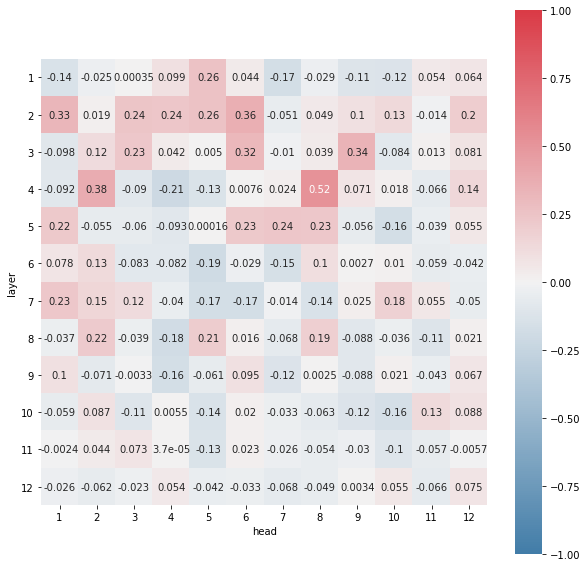

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(results.mean(axis=2), cmap=sns.diverging_palette(240, 10, sep=1, n=256), vmax=1, vmin=-1, xticklabels=range(1, 12+1), yticklabels=range(1, 12+1), square=True, annot=True, ax=ax)
plt.yticks(rotation=0)
plt.xlabel('head')
plt.ylabel('layer')

### Paper: Analyzing the Structure of Attention in a Transformer Language Model

#### Filtering Null Attention

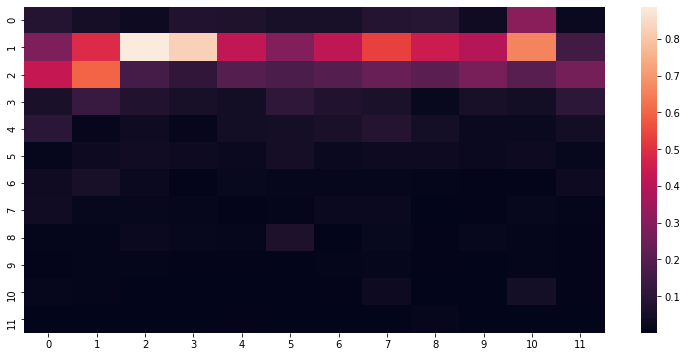

In [ ]:
sns.heatmap(torch.mean(torch.stack([finetuned_attention[i][:,:,:,0].sum(axis=2)/finetuned_attention[0].sum((2, 3)) for i in range(len(finetuned_attention))]), dim=0))

#### Part-of-Speech Tags

In [ ]:
class BertTokenizer:
    def __init__(self, vocab, t):
        self.vocab = vocab
        self._tokenizer = t

    def __call__(self, text):
        tokens = self._tokenizer.tokenize(text)
        words = []
        for token in tokens:
          if token.startswith('##'):
            words[-1] += token[2:]
          else:
            words.append(token)
        spaces = []
        for i, w in enumerate(words):
            if i < len(words)-1 and words[i+1].startswith('##'):
                spaces.append(False)
            elif i != len(words)-1:
                spaces.append(True)
            else:
                spaces.append(False)
        return Doc(self.vocab, words=words, spaces=spaces)

nlp = spacy.load('en_core_web_lg')
nlp.tokenizer = BertTokenizer(nlp.vocab, tokenizer)

In [ ]:
pos_lst = []
for idx in tqdm(range(len(finetuned_attention))):
  sentence = data.iloc[idx].sentence
  tokens = tokenizer.tokenize(sentence)
  bpe_i_2_word_i = []
  i = -1
  for token in tokens:
    if token.startswith('##'):
      bpe_i_2_word_i.append(i)
    else:
      i += 1
      bpe_i_2_word_i.append(i)
  doc = nlp(sentence)
  pos_words = [word.pos_ for word in doc]
  pos_lst.append(['[PAD]']+[pos_words[i] for i in bpe_i_2_word_i]+(finetuned_attention[idx].shape[2]-len(bpe_i_2_word_i)-1)*['[PAD]'])
pos_lst = [np.array(item) for item in pos_lst]

100%|██████████| 917/917 [00:13<00:00, 65.64it/s]


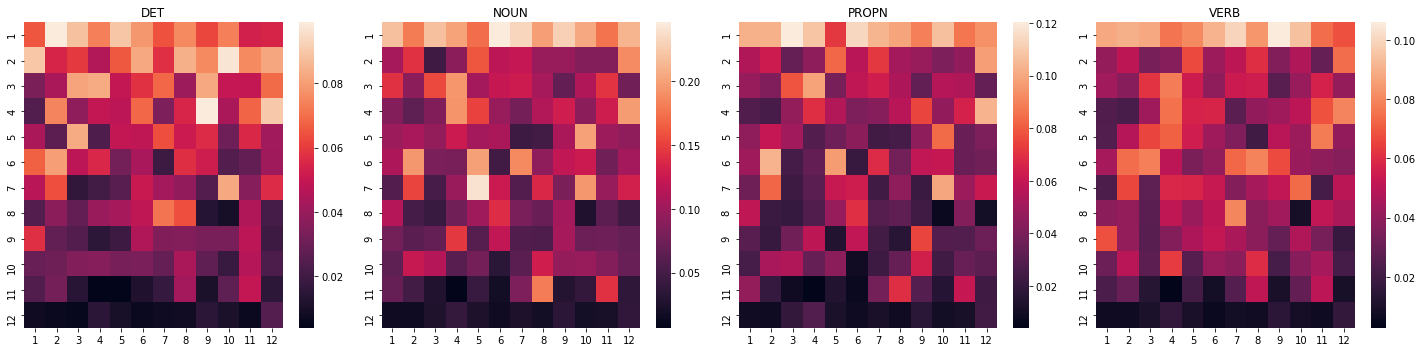

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
for idx, pos_tag in enumerate(['DET', 'NOUN', 'PROPN', 'VERB']):
  heatmap = sns.heatmap(torch.mean(torch.stack([attn[:, :, :, pos_lst[i]==pos_tag].sum((2,3))/attn.sum((2,3)) for i, attn in enumerate(finetuned_attention)]), axis=0), ax=axes[idx], xticklabels=range(1, 12+1), yticklabels=range(1, 12+1))
  #heatmap = sns.heatmap(torch.mean(torch.stack([attn[:, :,  pos_lst[i]==pos_tag, :].sum((2,3))/attn.sum((2,3)) for i, attn in enumerate(finetuned_attention)]), axis=0), ax=axes[idx], xticklabels=range(1, 12+1), yticklabels=range(1, 12+1))
  axes[idx].set_title(pos_tag)
plt.tight_layout()

In [ ]:
nlp = stanza.Pipeline('en',  processors='tokenize,mwt,pos,lemma,depparse', tokenize_pretokenized=True) # This sets up a default neural 

2021-02-17 03:19:48 WARNING: Can not find mwt: default from official model list. Ignoring it.
2021-02-17 03:19:48 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

2021-02-17 03:19:48 INFO: Use device: gpu
2021-02-17 03:19:48 INFO: Loading: tokenize
2021-02-17 03:19:48 INFO: Loading: pos
2021-02-17 03:19:51 INFO: Loading: lemma
2021-02-17 03:19:51 INFO: Loading: depparse
2021-02-17 03:19:53 INFO: Done loading processors!


In [ ]:
depparse = []
for idx in tqdm(range(len(finetuned_attention))):
  sentence = data.iloc[idx].sentence
  tokens = tokenizer.tokenize(sentence)
  words = []
  bpe_i_2_word_i = {}
  i = 0
  for j, token in enumerate(tokens):
    if token.startswith('##'):
      words[-1] += token[2:]
      bpe_i_2_word_i[j] = i
    else:
      words.append(token)
      i += 1
      bpe_i_2_word_i[j] = i
  word_i_2_bpe_i = {}
  for j, k in bpe_i_2_word_i.items():
    if k in word_i_2_bpe_i:
      word_i_2_bpe_i[k].append(j)
    else: 
      word_i_2_bpe_i[k] = [j]
  word_i_2_bpe_i[0] = ['root']
  doc = nlp([words])
  id_2_stuff = {word_stuff.id: word_stuff for sentence in doc.sentences for word_stuff in sentence.words}
  result = [(bpe_i, bpe, bpe_j, tokens[bpe_j], id_2_stuff[bpe_i_2_word_i[bpe_i]].deprel) for bpe_i, bpe in enumerate(tokens) for bpe_j in word_i_2_bpe_i[id_2_stuff[bpe_i_2_word_i[bpe_i]].head] if bpe_j != 'root']# for sentence in doc.sentences for word in sentence.words}
  depparse.append(result)

100%|██████████| 917/917 [00:57<00:00, 15.90it/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as a

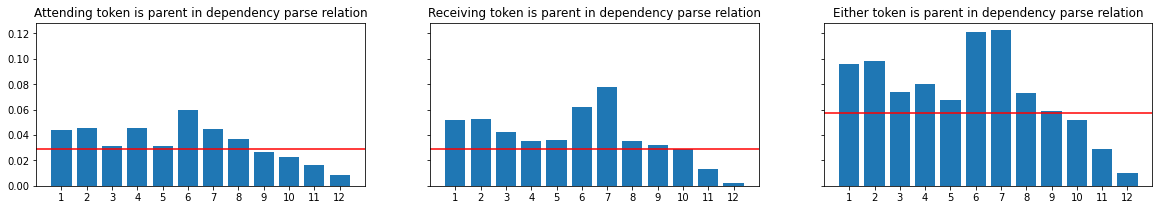

In [ ]:
results_receiving = np.zeros((12, len(finetuned_attention)))
baseline_receiving = np.zeros(len(finetuned_attention))
results_attending = np.zeros((12, len(finetuned_attention)))
baseline_attending = np.zeros(len(finetuned_attention))
results_either = np.zeros((12, len(finetuned_attention)))
baseline_either = np.zeros(len(finetuned_attention))
for i in range(len(finetuned_attention)):
  attn = finetuned_attention[i]
  j, _, k, __, ___ = map(np.array, zip(*depparse[i]))
  mask = np.zeros((attn.shape[2], attn.shape[2]))
  mask[[*np.stack([j+1, k+1], axis=1).T]] = 1
  attn_dp = np.multiply(attn, mask)
  results_receiving[:, i] = attn_dp.sum(axis=(1,2,3))/attn.sum(axis=(1,2,3))
  baseline_receiving[i] = len(j)/attn.shape[2]**2
  mask = np.zeros((attn.shape[2], attn.shape[2]))
  mask[[*np.stack([k+1, j+1], axis=1).T]] = 1
  attn_dp = np.multiply(attn, mask)
  results_attending[:, i] = attn_dp.sum(axis=(1,2,3))/attn.sum(axis=(1,2,3))
  baseline_attending[i] = len(j)/attn.shape[2]**2
  j, k = np.hstack((j, k)), np.hstack((k, j))
  mask = np.zeros((attn.shape[2], attn.shape[2]))
  mask[[*np.stack([j+1, k+1], axis=1).T]] = 1
  attn_dp = np.multiply(attn, mask)
  results_either[:, i] = attn_dp.sum(axis=(1,2,3))/attn.sum(axis=(1,2,3))
  baseline_either[i] = len(j)/attn.shape[2]**2
results_receiving = results_receiving.mean(axis=1)
results_attending = results_attending.mean(axis=1)
results_either = results_either.mean(axis=1)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 3), sharey=True)
_ = axes[0].bar(range(1, 12+1), results_attending)
_ = axes[0].axhline(y=baseline_attending.mean(), color='r', linestyle='-')
_ = axes[0].set_xticks(range(1, 12+1))
_ = axes[0].set_title('Attending token is parent in dependency parse relation')
_ = axes[1].bar(range(1, 12+1), results_receiving)
_ = axes[1].axhline(y=baseline_receiving.mean(), color='r', linestyle='-')
_ = axes[1].set_xticks(range(1, 12+1))
_ = axes[1].set_title('Receiving token is parent in dependency parse relation')
_ = axes[2].bar(range(1, 12+1), results_either)
_ = axes[2].axhline(y=baseline_either.mean(), color='r', linestyle='-')
_ = axes[2].set_xticks(range(1, 12+1))
_ = axes[2].set_title('Either token is parent in dependency parse relation')

### Paper: Are Sixteen Heads Really Better than One?
- https://github.com/abidlabs/pytorch-transformers/blob/master/examples/run_bertology.py

#### Head importance & Attention Entropy
- Grab fine-tuned model.
- Backprop dev set.

In [ ]:
#!python run_bertology.py --seed 2020 --task lcp --task_def 'data_complex/lcp.yml' --checkpoint 'checkpoints/bert-cased_lcp-single_2021-01-19T0309/bert_model_base_cased.pt' --output_dir 'checkpoints/bert-cased_lcp-single_2021-01-19T0309/' --prep_input 'data_complex/bert_base_cased/lcp_test.json' --cuda True --batch_size 8
!python run_bertology.py --seed 2020 --task lcp --task_def 'data_complex/lcp.yml' --checkpoint 'checkpoints/bert-cased_lcp-single_2021-01-19T0309/model_4.pt' --output_dir 'checkpoints/bert-cased_lcp-single_2021-01-19T0309/' --prep_input 'data_complex/bert_base_cased/lcp_test.json' --cuda True --batch_size 8

In [ ]:
head_importance = np.load('checkpoints/bert-cased_lcp-single_2021-01-19T0309/head_importance.npy')
attn_entropy = np.load('checkpoints/bert-cased_lcp-single_2021-01-19T0309/attn_entropy.npy')

In [ ]:
#results = []
#results.append(head_importance)
#results_2 = []
#results_2.append(attn_entropy)

In [ ]:
#results = []
#results.append(head_importance)
head_importance = np.stack(results).mean(axis=0)
attn_entropy = np.stack(results_2).mean(axis=0)

In [ ]:
head_importance = np.load('checkpoints/bert-cased_lcp-single_2021-01-19T0309/finetuned_head_importance.npy')
attn_entropy = np.load('checkpoints/bert-cased_lcp-single_2021-01-19T0309/finetuned_attn_entropy.npy')
#np.save("checkpoints/bert-cased_lcp-single_2021-01-19T0309/pretrained_head_importance.npy", head_importance)
#np.save("checkpoints/bert-cased_lcp-single_2021-01-19T0309/pretrained_attn_entropy.npy", attn_entropy)
#np.save("checkpoints/bert-cased_lcp-single_2021-01-19T0309/finetuned_head_importance.npy", head_importance)
#np.save("checkpoints/bert-cased_lcp-single_2021-01-19T0309/finetuned_attn_entropy.npy", attn_entropy)

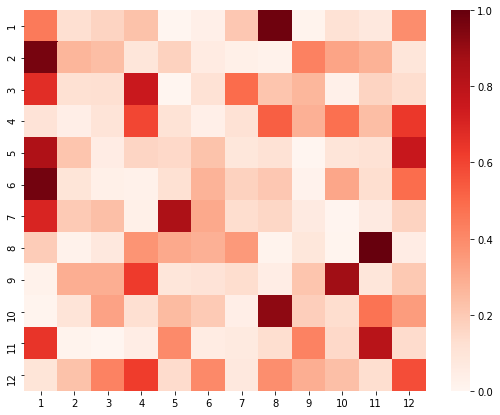

In [ ]:
# new finetuned head importance of each layer
plt.rcParams['figure.figsize'] = [9, 7]
sns.heatmap(head_importance, cmap="Reds", xticklabels=range(1, 12+1), yticklabels=range(1, 12+1))

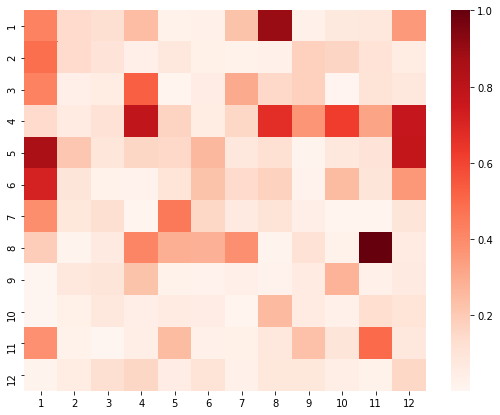

In [ ]:
# new finetuned head importance w/o normalization of each layer
plt.rcParams['figure.figsize'] = [9, 7]
sns.heatmap(head_importance, cmap="Reds", xticklabels=range(1, 12+1), yticklabels=range(1, 12+1))

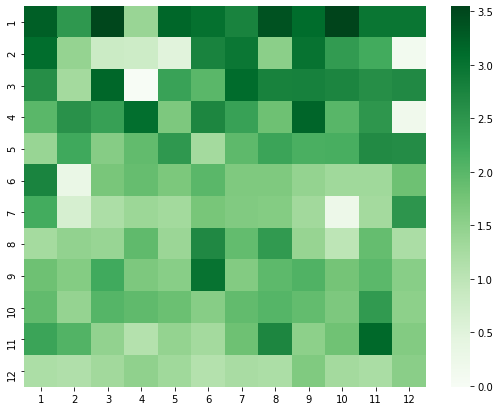

In [ ]:
# new finetuned entropy of each layer
plt.rcParams['figure.figsize'] = [9, 7]
sns.heatmap(attn_entropy, cmap="Greens", xticklabels=range(1, 12+1), yticklabels=range(1, 12+1))

In [ ]:
with open('data_complex/bert_base_cased/lcp_test.json', 'r') as file_1:
  with open('checkpoints/bert-cased_lcp-single_2021-01-19T0309/lcp_test.json', 'a') as file_2:
    for i, line in enumerate(file_1):
      d = json.loads(line)
      d['label'] = data['complexity'].iloc[i]
      file_2.write(json.dumps(d)+'\n')

In [ ]:
!python run_bertology.py --do_proper True --seed 2020 --task lcp --task_def 'data_complex/lcp.yml' --checkpoint 'checkpoints/bert-cased_lcp-single_2021-01-19T0309/model_4.pt' --output_dir 'checkpoints/bert-cased_lcp-single_2021-01-19T0309/' --prep_input 'data_complex/bert_base_cased/lcp_test.json' --cuda True --batch_size 8

In [ ]:
results = pkl.load(open('checkpoints/bert-cased_lcp-single_2021-01-19T0309/results.pkl', 'rb'))
head_importance_proper = torch.stack([item[1] for item in results]).mean(axis=0).cpu()
std_proper = torch.stack([item[1] for item in results]).std(axis=0).cpu()

In [ ]:
!python run_bertology.py --do_improper True --seed 2020 --task lcp --task_def 'data_complex/lcp.yml' --checkpoint 'checkpoints/bert-cased_lcp-single_2021-01-19T0309/model_4.pt' --output_dir 'checkpoints/bert-cased_lcp-single_2021-01-19T0309/' --prep_input 'data_complex/bert_base_cased/lcp_test.json' --cuda True --batch_size 8

In [ ]:
results = pkl.load(open('checkpoints/bert-cased_lcp-single_2021-01-19T0309/results.pkl', 'rb'))
head_importance_improper = torch.stack([item[1] for item in results]).mean(axis=0).cpu()
std_improper = torch.stack([item[1] for item in results]).std(axis=0).cpu()

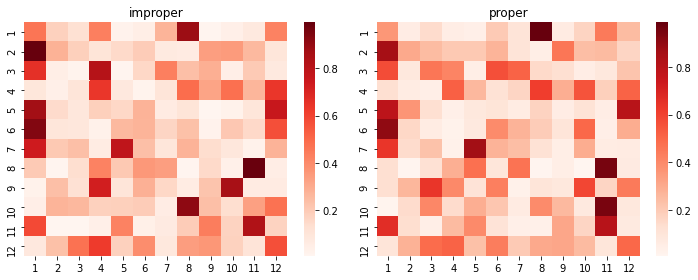

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
sns.heatmap(head_importance_improper, cmap="Reds", xticklabels=range(1, 12+1), yticklabels=range(1, 12+1), ax=axes[0])
axes[0].set_title('improper')
sns.heatmap(head_importance_proper, cmap="Reds", xticklabels=range(1, 12+1), yticklabels=range(1, 12+1), ax=axes[1])
axes[1].set_title('proper')
plt.tight_layout()

### Paper: Attention analysis
- https://github.com/clarkkev/attention-analysis

In [ ]:
!git clone https://github.com/clarkkev/attention-analysis.git

In [ ]:
import sys
sys.path.append('../attention-analysis/')
from bpe_utils import tokenize_and_align
import itertools

#### Dependency syntax

In [ ]:
sentences = [tokenizer.convert_tokens_to_string(tokens) for tokens in tokens_lst]
with open('../from_macbook/sentences.txt', 'a') as file:
  for i, sentence in enumerate(sentences):
    if i != 0:
      file.write('\n')
    file.write(sentence)

In [ ]:
depparse = pkl.load(open('../from_macbook/depparse.pkl', 'rb'))
sep_bracket_idx = [[i for i, tup in enumerate(dp) if tup[0] == 'SEP'][0]-1 for dp in depparse]
depparse = [dp[3:sep_bracket_idx[i]] for i, dp in enumerate(depparse)]

def tokenize_and_align_mod(tokenizer_mod, tokens, head, deprel, target):
  """Given already-tokenized text (as a list of strings), returns a list of
  lists where each sub-list contains BERT-tokenized tokens for the
  correponding word."""
  result = []
  for token, h, d in zip(tokens, head, deprel):
    bpes = tokenizer_mod.tokenize(token)
    for bpe in bpes:
      result.append((bpe, h, d))
  result = ['[CLS]'] + result + ['[SEP]'] + tokenizer_mod.tokenize(target) + ['[SEP]']
  return result

In [ ]:
for i in tqdm(range(len(depparse))):
  tokens, head, deprel = map(list, zip(*depparse[i]))
  result = tokenize_and_align_mod(tokenizer, tokens, head, deprel, data.iloc[i]['token'])
  depparse[i] = result[1:[idx for idx, item in enumerate(result) if item == '[SEP]'][0]]
  if i == 320:
    depparse[i][40] = ('##f', 28, 'conj')
  elif i == 322:
    depparse[i][7] = ('##CA', 12, 'compound')
  elif i == 330:
    depparse[i][34] = ('cannot', 24, 'aux')
    del depparse[i][35]
  elif i == 339:
    depparse[i][49] = ('##R', 37, 'nmod')
    depparse[i].insert(50, ('##s', 37, 'nmod'))
  elif i == 341:
    depparse[i][16] = ('##R', 12, 'nmod')
    depparse[i].insert(17, ('##s', 12, 'nmod'))
  elif i == 356:
    depparse[i][27] = ('##p', 15, 'appos')
  elif i == 394:
    depparse[i][49] = ('##R', 37, 'nmod')
    depparse[i].insert(50, ('##s', 37, 'nmod'))
  elif i == 452:
    depparse[i][1] = ('##53', 4, 'nummod')
    depparse[i][40] = ('##D', 34, 'appos')
    depparse[i].insert(41, ('##a', 34, 'appos'))
  elif i == 460:
    depparse[i][1] = ('##53', 4, 'nummod')
    depparse[i][40] = ('##D', 34, 'appos')
    depparse[i].insert(41, ('##a', 34, 'appos'))
  elif i == 465:
    depparse[i][25] = ('##R', 11, 'conj')
    depparse[i].insert(26, ('##s', 11, 'conj'))
  elif i == 565:
    depparse[i][33] = ('##D', 25, 'compound')
    depparse[i].insert(34, ('##a', 25, 'compound'))
  same = tokens_lst[i][1:tokens_lst[i].index('[SEP]')] == [item[0] for item in depparse[i]]
  if not same:
    if len(tokens_lst[i][1:tokens_lst[i].index('[SEP]')]) != len([item[0] for item in depparse[i]]):
      break 
    else:
      for j, (token_1, token_2) in enumerate(zip(tokens_lst[i][1:tokens_lst[i].index('[SEP]')], [item[0] for item in depparse[i]])):
        if token_1 != token_2:
          stuff = depparse[i][j]
          stuff = tuple([token_1, stuff[1], stuff[2]])
          depparse[i][j] = stuff

100%|██████████| 917/917 [00:02<00:00, 447.15it/s]


In [ ]:
finetuned_attention_mod = [attn[:, :, :tokens_lst[i].index('[SEP]')+1, :tokens_lst[i].index('[SEP]')+1] for i, attn in enumerate(finetuned_attention)]

In [ ]:
test_data = []
for i in range(len(tokens_lst)):
  item = {}
  item['words'] = tokens_lst[i][1:tokens_lst[i].index('[SEP]')]
  _, heads, relns = map(list, zip(*depparse[i]))
  item['heads'] = heads
  item['relns'] = relns
  item['attns'] = finetuned_attention_mod[i]
  test_data.append(item)

In [ ]:
print("words:", test_data[0]["words"])
print("heads:", test_data[0]["heads"])
print("relns:", test_data[0]["relns"])
# Attention maps are 9x9 because [CLS] and [SEP] are added
print("attns: a tensor with shape", test_data[0]["attns"].shape)

words: ['I', 'will', 'no', 'more', 'speak', 'much', 'with', 'you', ',', 'for', 'the', 'prince', 'of', 'the', 'world', 'comes', ',', 'and', 'he', 'has', 'nothing', 'in', 'me', '.']
heads: [5, 5, 4, 5, 0, 5, 8, 5, 16, 16, 12, 16, 15, 15, 12, 5, 20, 20, 20, 5, 20, 23, 21, 5]
relns: ['nsubj', 'aux', 'advmod', 'advmod', 'root', 'advmod', 'case', 'obl', 'punct', 'mark', 'det', 'nsubj', 'case', 'det', 'nmod', 'advcl', 'punct', 'cc', 'nsubj', 'conj', 'obj', 'case', 'nmod', 'punct']
attns: a tensor with shape torch.Size([12, 12, 26, 26])


In [ ]:
# Find the most common relations in our data
reln_counts = collections.Counter()
for example in test_data:
  for reln in example["relns"]:
    reln_counts[reln] += 1
print(reln_counts.most_common(10))

[('punct', 4220), ('case', 3770), ('nmod', 2984), ('det', 2728), ('amod', 2562), ('conj', 2246), ('compound', 2207), ('obl', 1808), ('nsubj', 1757), ('obj', 1344)]


In [ ]:
# Code for evaluating individual attention maps and baselines

def evaluate_predictor(prediction_fn):
  """Compute accuracies for each relation for the given predictor."""
  n_correct, n_incorrect = collections.Counter(), collections.Counter()
  for example in test_data:
    words = example["words"]
    predictions = prediction_fn(example)
    for i, (p, y, r) in enumerate(zip(predictions, example["heads"],
                                      example["relns"])):
      is_correct = (p == y)
      if r == "poss" and p < len(words):
        # Special case for poss (see discussion in Section 4.2)
        if i < len(words) and words[i + 1] == "'s" or words[i + 1] == "s'":
          is_correct = (predictions[i + 1] == y)
      if is_correct:
        n_correct[r] += 1
        n_correct["all"] += 1
      else:
        n_incorrect[r] += 1
        n_incorrect["all"] += 1
  return {k: n_correct[k] / float(n_correct[k] + n_incorrect[k])
          for k in n_incorrect.keys()}

def attn_head_predictor(layer, head, mode="normal"):
  """Assign each word the most-attended-to other word as its head."""
  def predict(example):
    attn = np.array(example["attns"][layer][head])
    if mode == "transpose":
      attn = attn.T
    elif mode == "both":
      attn += attn.T
    else:
      assert mode == "normal"
    # ignore attention to self and [CLS]/[SEP] tokens
    attn[range(attn.shape[0]), range(attn.shape[0])] = 0
    attn = attn[1:-1, 1:-1]
    return np.argmax(attn, axis=-1) + 1  # +1 because ROOT is at index 0
  return predict

def offset_predictor(offset):
  """Simple baseline: assign each word the word a fixed offset from
  it (e.g., the word to its right) as its head."""
  def predict(example):
    return [max(0, min(i + offset + 1, len(example["words"])))
            for i in range(len(example["words"]))]
  return predict

def get_scores(mode="normal"):
  """Get the accuracies of every attention head."""
  scores = collections.defaultdict(dict)
  for layer in range(12):
    for head in range(12):
      scores[layer][head] = evaluate_predictor(
          attn_head_predictor(layer, head, mode))
  return scores

# attn_head_scores[direction][layer][head][dep_relation] = accuracy
attn_head_scores = {
    "dep->head": get_scores("normal"),
    "head<-dep": get_scores("transpose")
}
# baseline_scores[offset][dep_relation] = accuracy
baseline_scores = {
    i: evaluate_predictor(offset_predictor(i)) for i in range(-3, 3)
}

In [ ]:
def get_all_scores(reln):
  """Get all attention head scores for a particular relation."""
  all_scores = []
  for key, layer_head_scores in attn_head_scores.items():
    for layer, head_scores in layer_head_scores.items():
      for head, scores in head_scores.items():
        all_scores.append((scores[reln], layer, head, key))
  return sorted(all_scores, reverse=True)

In [ ]:
for row, (reln, _) in enumerate([("all", 0)] + reln_counts.most_common()):
  if reln == "root" or reln == "punct":
    continue
  if reln_counts[reln] < 100 and reln != "all":
    break
  uas, layer, head, direction = sorted(
      s for s in get_all_scores(reln))[-1]
  baseline_uas, baseline_offset = max(
      (scores[reln], i) for i, scores in baseline_scores.items())
  print("{:8s} | {:5d} | attn: {:.1f} | offset={:2d}: {:.1f} | {:}-{:} {:}".format(
      reln[:8], reln_counts[reln], 100 * uas, baseline_offset, 100 * baseline_uas,
      layer, head, direction))

all      |     0 | attn: 13.2 | offset= 1: 11.7 | 5-6 dep->head
case     |  3770 | attn: 23.4 | offset= 1: 17.4 | 5-4 dep->head
nmod     |  2984 | attn: 12.6 | offset=-3: 12.6 | 5-7 dep->head
det      |  2728 | attn: 32.1 | offset= 1: 29.0 | 6-4 dep->head
amod     |  2562 | attn: 18.4 | offset= 1: 18.3 | 6-9 dep->head
conj     |  2246 | attn: 9.4 | offset=-2: 4.8 | 8-6 dep->head
compound |  2207 | attn: 16.3 | offset= 1: 15.8 | 0-3 dep->head
obl      |  1808 | attn: 8.6 | offset=-3: 8.9 | 8-6 dep->head
nsubj    |  1757 | attn: 23.7 | offset= 1: 19.4 | 7-4 dep->head
obj      |  1344 | attn: 26.3 | offset=-2: 15.4 | 5-7 dep->head
cc       |  1225 | attn: 15.8 | offset= 1: 15.8 | 5-1 head<-dep
advmod   |   901 | attn: 20.3 | offset= 1: 19.8 | 5-6 dep->head
mark     |   754 | attn: 24.9 | offset= 1: 21.4 | 6-8 dep->head
aux      |   581 | attn: 33.0 | offset= 1: 29.4 | 7-4 dep->head
flat     |   553 | attn: 15.7 | offset=-1: 8.5 | 8-0 dep->head
appos    |   550 | attn: 11.3 | offset=-3: 10

#### Relative position & Attending to separator tokens

In [ ]:
finetuned_attention_numpy = [item.numpy() for item in finetuned_attention]
n_docs = len(tokens_lst)

In [ ]:
avg_attns = {
    k: np.zeros((12, 12)) for k in [
      "self", "right", "left", "sep", "sep_sep", "rest_sep",
      "cls", "punct"]
}

In [ ]:
print("Computing token stats")
for tokens, attns in tqdm(zip(tokens_lst, finetuned_attention_numpy)):
  n_tokens = attns.shape[-1]
  # create masks indicating where particular tokens are
  seps, clss, puncts = (np.zeros(n_tokens) for _ in range(3))
  for position, token in enumerate(tokens):
    if token == "[SEP]":
      seps[position] = 1
    if token == "[CLS]":
      clss[position] = 1
    if token == "." or token == ",":
      puncts[position] = 1
  # create masks indicating which positions are relevant for each key
  sep_seps = np.ones((n_tokens, n_tokens))
  sep_seps *= seps[np.newaxis]
  sep_seps *= seps[:, np.newaxis]
  rest_seps = np.ones((n_tokens, n_tokens))
  rest_seps *= (np.ones(n_tokens) - seps)[:, np.newaxis]
  rest_seps *= seps[np.newaxis]
  selectors = {
      "self": np.eye(n_tokens, n_tokens),
      "right": np.eye(n_tokens, n_tokens, 1),
      "left": np.eye(n_tokens, n_tokens, -1),
      "sep": np.tile(seps[np.newaxis], [n_tokens, 1]),
      "sep_sep": sep_seps,
      "rest_sep": rest_seps,
      "cls": np.tile(clss[np.newaxis], [n_tokens, 1]),
      "punct": np.tile(puncts[np.newaxis], [n_tokens, 1]),
  }
  # get the average attention for each token type
  for key, selector in selectors.items():
    if key == "sep_sep":
      denom = 2
    elif key == "rest_sep":
      denom = n_tokens - 2
    else:
      denom = n_tokens
    avg_attns[key] += (
        (attns * selector[np.newaxis, np.newaxis]).sum(-1).sum(-1) /
        (n_docs * denom))

13it [00:00, 115.38it/s]

Computing token stats


917it [00:08, 108.80it/s]


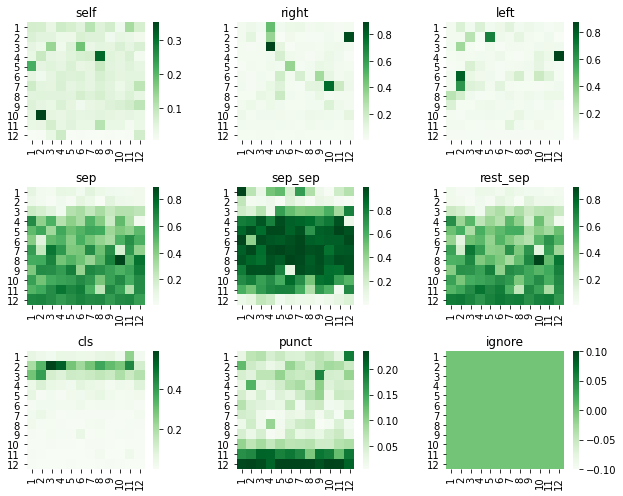

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3)
for i, (k, avg_attn) in enumerate(avg_attns.items()):
  row = i//3
  col = i%3
  ax = axes[row, col]
  sns.heatmap(avg_attns[k], cmap="Greens", square=True, xticklabels=range(1, 12+1), yticklabels=range(1, 12+1), ax=ax)
  ax.set_title(k)
sns.heatmap(np.zeros((12, 12)), cmap="Greens", square=True, xticklabels=range(1, 12+1), yticklabels=range(1, 12+1), ax=axes[2,2])
axes[2,2].set_title('ignore')
fig.tight_layout()

#### Focused vs. broad attention

In [ ]:
uniform_attn_entropy = 0  # entropy of uniform attention
entropies = np.zeros((12, 12))  # entropy of attention heads
entropies_cls = np.zeros((12, 12))  # entropy of attention from [CLS]

print("Computing entropy stats")
for tokens, attns in tqdm(zip(tokens_lst, finetuned_attention_numpy)):
  attns = 0.9999 * attns + (0.0001 / attns.shape[-1])  # smooth to avoid NaNs
  uniform_attn_entropy -= np.log(1.0 / attns.shape[-1])
  entropies -= (attns * np.log(attns)).sum(-1).mean(-1)
  entropies_cls -= (attns * np.log(attns))[:, :, 0].sum(-1)

uniform_attn_entropy /= n_docs
entropies /= n_docs
entropies_cls /= n_docs

42it [00:00, 409.37it/s]

Computing entropy stats


917it [00:03, 295.41it/s]


In [ ]:
print('uniform_attn_entropy: ', uniform_attn_entropy)

uniform_attn_entropy:  3.632464546130043


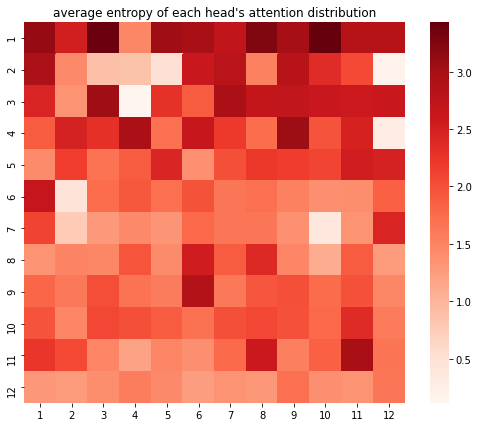

In [ ]:
sns.heatmap(entropies, cmap="Reds", square=True, xticklabels=range(1, 12+1), yticklabels=range(1, 12+1))
_ = plt.title('average entropy of each head\'s attention distribution')

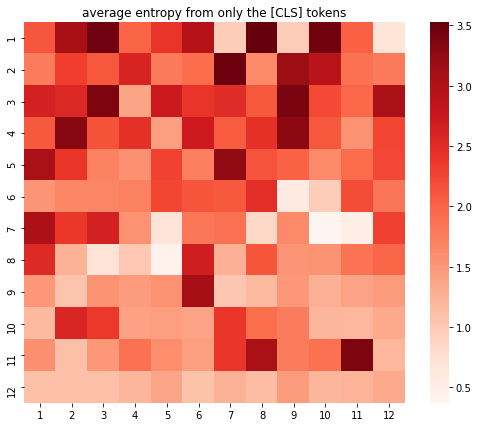

In [ ]:
sns.heatmap(entropies_cls, cmap="Reds", square=True, xticklabels=range(1, 12+1), yticklabels=range(1, 12+1))
_ = plt.title('average entropy from only the [CLS] tokens')